In [84]:
# Load dependencies
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pylab as pl

import itertools
from chdir import chdir

from sklearn import decomposition
from scipy.stats import zscore
from IPython.display import display, HTML, Image

pd.options.mode.chained_assignment = None

In [114]:
rid2sig = pd.read_table('rid2symbol.txt',header=None)
ensg2sig = pd.read_table('ensg2symbol.txt',header=None)

genesymbols = np.unique(rid2sig.iloc[:,1].tolist() + ensg2sig.iloc[:,1].tolist())

In [85]:
control = ['cd1','cd2','cd3']
treated = ['gat1','gat2','gat3']

# Load data
dat = {}
df = pd.read_table('GATA1_marrow_foldchange.txt',sep='\t',index_col=0)[control + treated]
dat['marrow'] = df[np.std(df,axis=1) != 0]
df = pd.read_table('GATA1_spleen_foldchange.txt',sep='\t',index_col=0)[control + treated]
dat['spleen'] = df[np.std(df,axis=1) != 0]

genes = np.sort(np.intersect1d(dat['marrow'].index.values, dat['spleen'].index.values))

dat['marrow'] = dat['marrow'].loc[genes].reindex(genes)
dat['spleen'] = dat['spleen'].loc[genes].reindex(genes)

print len(dat['spleen'].index), len(np.unique(dat['spleen'].index))

print dat['marrow'].shape
print dat['spleen'].shape

dgenes = ['STAT1','STAT3','STAT5A','STAT5B','SMAD2','SMAD3','GATA1','GATA2','JUN']

def do_chdir(C,T,genes):
    ctr = dat[tissue][list(C)]
    trt = dat[tissue][list(T)]
    name = ''.join([ C[i][-1] for i in range(len(C))])+'-'+''.join([ T[i][-1] for i in range(len(T))])
    chGenes, chVec = chdir(ctr,trt,genes)
    return pd.Series(chVec, name=name, index=chGenes)
    

28612 28612
(28612, 6)
(28612, 6)


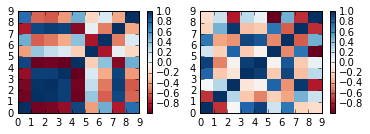

In [86]:
control = ['cd1','cd2','cd3']
treated = ['gat1','gat2','gat3']

corr = {}

for tissue in dat.keys():
    frames = []
    for C in itertools.combinations(control, 2):
        for T in itertools.combinations(treated, 2):
            frames.append( do_chdir(C,T,genes) )
            
    df = pd.concat(frames,axis=1)
    corr[tissue] = pd.DataFrame(np.corrcoef(df.values), index=df.index, columns=df.index)


plt.subplot(221)
mat = corr['spleen'].loc[dgenes,dgenes]
pl.pcolor(mat, cmap='RdBu')
pl.colorbar()

plt.subplot(222)
mat = corr['marrow'].loc[dgenes,dgenes]
pl.pcolor(mat, cmap='RdBu')
pl.colorbar()

pl.show()


In [115]:
cutoff = 0.9

spleen_degs = pd.read_table('spleen_cd_DEGs_filt.txt',index_col=0).index.values
marrow_degs = pd.read_table('marrow_cd_DEGs_filt.txt',index_col=0).index.values

spleen_degs = [ x for x in spleen_degs if x in genesymbols ]

print len(spleen_degs)

A = corr['spleen'].loc[spleen_degs,spleen_degs].fillna(0.0)

print A.shape

# Build adjacency matrix
A[ abs(A) < cutoff ] = 0
A[ abs(A) >= cutoff ] = 1

nonempty = np.sum(A, axis=1) > 2
print nonempty[0]

A = A.loc[nonempty,nonempty]


719
(719, 719)
True


In [132]:
# from igraph import *
import igraph as ig
# g = Graph()

# g = ig.Graph.Erdos_Renyi(n=10, m=16)
# g.vs["name"] = [ str(x) for x in range(10) ]
# g.vs["label"] = g.vs["name"]
# color_dict = { True:"blue",False,"red" }

# print "degrees:",g.degree()
# g = Graph.Adjacency(A)

# clust = g.community_leading_eigenvector()
# print summary(clust)

mat = A.values
np.fill_diagonal(mat,0.0)

g = ig.Graph.Adjacency(mat.tolist()).as_undirected()
g.vs["label"] = A.index.values
cg = g.community_leading_eigenvector()
subgraphs = cg.subgraphs()
print len(subgraphs)

layout = g.layout_kamada_kawai()

for i in range(len(subgraphs)):
    subg = subgraphs[i]
    genes = subg.vs["label"]
    with open("network"+str(i)+".txt",'w') as f: f.write('\n'.join(genes)+'\n')
    plot(subgraphs[i], "network"+str(i)+".pdf", layout = layout, bbox = (800, 800), margin = 20)


# singletons = cg.vs.select(_degree=0)
# cg.delete_vertices(singletons)
print summary(cg)

# layout = g.layout_fruchterman_reingold()
layout = g.layout_kamada_kawai()

# plot(cg, "network.pdf", layout = layout,
# #      vertex_color = [ "red" if int(x)%2==0 else "blue" for x in g.vs["name"] ],
#      bbox = (1000, 1000), margin = 20)


5
Clustering with 711 elements and 5 clusters
None


In [24]:
print g.vs["name"]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


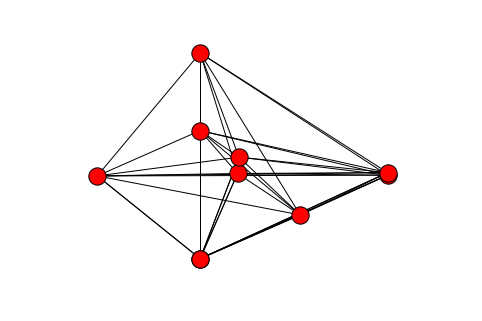

In [50]:
import networkx as nx
G = nx.Graph()
# nx.draw_random(G)
G = nx.complete_graph(10)
# nx.draw_random(G)
# nx.draw_circular(G)
nx.draw_spectral(G)
plt.show()
# plt.savefig("path.png")